In [1]:
import pandas as pd
import numpy as np
import re
import selenium 
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
import nltk
import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from spellchecker import SpellChecker
from collections import Counter

C:\Users\student\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### Objective: Create a ML model that can accurately predict the listprice of a home based on variables pulled from Home.com

#### Goals:
1. Find which variables are most important in understanding the price of a home.
2. Use keywords from the description to group homes by percentile.


## Clean the housing data

In [9]:
NJ_house = pd.read_csv('NJ_House.csv')
NJ_mobile_home = pd.read_csv('NJ_Mobile_home.csv')
NJ_townhouse = pd.read_csv('NJ_Townhouse.csv')
NJ_condo = pd.read_csv('NJ_Condo.csv')

frames = [NJ_house, NJ_mobile_home, NJ_townhouse, NJ_condo]

NJ_real_estate = pd.concat(frames)

NJ_real_estate.head()

,Unnamed: 0,address,price,beds,baths,sq_ft,description,realtor,agency,house_type
0,0,"306 Stephan Ave, Toms River, NJ 08753","$599,999",3 Beds,3 Baths,"1,931 Sq Ft",Amazing opportunity to own Waterfront property...,Michael Suppa,Ward Wight Sotheby's International Realty,House
1,1,"37 Coolidge Pl, West Long Branch, NJ 07764","$899,900",3 Beds,2 Baths,"1,734 Sq Ft",Rare Find! Expanded Ranch situated on pictures...,Michele Ashkenazi,Schecher Realty,House
2,2,"854 Brown Ct, Toms River, NJ 08753","$899,000",4 Beds,3 Baths,"3,224 Sq Ft",Welcome to 854 Brown Court! This masterpiece i...,Fraidy Kaluszyner,EXP Realty,House
3,3,"76 W 42nd St, Bayonne, NJ 07002","$775,000",5 Beds,3 Baths,"2,964 Sq Ft",This well-maintained two-family investment pro...,Gary Mawson,EXP Realty,House
4,4,"15 N Crest Pl, Lakewood, NJ 08701","$729,000",6 Beds,4 Baths,"2,331 Sq Ft",Welcome to your dream home in prime location n...,Devora Berger,Keller Williams Shore Properties,House


Drop the unamed row

In [10]:
NJ_real_estate.drop(columns=["Unnamed: 0"], axis=1, inplace=True)
NJ_real_estate.reset_index(drop=True, inplace=True)

Split address into street, zip, city, and state

In [11]:
split_cols = NJ_real_estate.address.str.split(',', expand=True)
split_cols.drop(split_cols.columns[3], axis=1, inplace=True)

In [12]:
split_cols.columns = ['street', 'city', 'state/zip']  # Specify the desired column names
NJ_real_estate = pd.concat([NJ_real_estate, split_cols], axis=1)
NJ_real_estate.drop('address', axis=1, inplace=True)

In [13]:
NJ_real_estate[['state','zip']] = NJ_real_estate['state/zip'].str.split(expand=True)

In [14]:
NJ_real_estate.drop(['state/zip','state'], axis=1, inplace=True)

Extract the number from beds, baths, and square footage

In [15]:
NJ_real_estate['sq_ft'] = NJ_real_estate['sq_ft'].str.replace(',', '')

for col in ['beds', 'baths','sq_ft']:
    NJ_real_estate[col] = NJ_real_estate[col].str.extract(r'(\d+)')

In [16]:
NJ_real_estate['price'] = NJ_real_estate['price'].str.replace('$', '').str.replace(',', '')
NJ_real_estate['price'] = NJ_real_estate['price'].str.extract(r'(\d+)')

Lowercase description, realtor, agency, house type, street, and city

In [17]:
for col in ['description','realtor', 'agency', 'house_type', 'street','city']:
    NJ_real_estate[col] = NJ_real_estate[col].str.lower()

In [18]:
pattern = r'[^\w\s]'
NJ_real_estate['agency'] = NJ_real_estate['agency'].str.replace(pattern, '')

In [19]:
NJ_real_estate.head()

,price,beds,baths,sq_ft,description,realtor,agency,house_type,street,city,zip
0,599999,3,3,1931,amazing opportunity to own waterfront property...,michael suppa,ward wight sothebys international realty,house,306 stephan ave,toms river,08753
1,899900,3,2,1734,rare find! expanded ranch situated on pictures...,michele ashkenazi,schecher realty,house,37 coolidge pl,west long branch,07764
2,899000,4,3,3224,welcome to 854 brown court! this masterpiece i...,fraidy kaluszyner,exp realty,house,854 brown ct,toms river,08753
3,775000,5,3,2964,this well-maintained two-family investment pro...,gary mawson,exp realty,house,76 w 42nd st,bayonne,07002
4,729000,6,4,2331,welcome to your dream home in prime location n...,devora berger,keller williams shore properties,house,15 n crest pl,lakewood,08701


Change the dtypes of price, beds, baths, and square footage to a float

In [20]:
NJ_real_estate[['price','beds','baths','sq_ft']] = NJ_real_estate[['price','beds','baths','sq_ft']].astype(float)

In [21]:
NJ_real_estate['description'] = NJ_real_estate['description'].astype(str)

In [22]:
NJ_real_estate.dtypes

price          float64
beds           float64
baths          float64
sq_ft          float64
description     object
realtor         object
agency          object
house_type      object
street          object
city            object
zip             object
dtype: object

Remove entries that do not have a description.

In [23]:
NJ_real_estate.replace('nan',np.nan, inplace=True)
NJ_real_estate.dropna(subset=['description'],inplace=True)

Impute the missing values

In [24]:
for col in ['beds','baths','sq_ft']:
    nan_values = NJ_real_estate[col].isna().sum()
    print(f'{col}:', nan_values)

beds: 218
baths: 535
sq_ft: 901


Square footage has a lot of missing values, close to half the dataset. Instead of imputing mean, median, and mode I want to see if I can find the square footage in the description and use that.

In [25]:
sq_ft_missing = NJ_real_estate[NJ_real_estate.sq_ft.isna()]

sq_ft_missing.head()

,price,beds,baths,sq_ft,description,realtor,agency,house_type,street,city,zip
7,559999.0,4.0,4.0,NaN,introducing a meticulously maintained dream ho...,john a. scipione,exp realty llc,house,11 emmet st,belleville,07109
9,585500.0,3.0,2.0,NaN,"this charming 1-family house in hackensack, nj...",bishoy megalla,keller williams team realty,house,225 elm ave,hackensack,07601
12,499000.0,3.0,2.0,NaN,situated in the the heart of denville on a sce...,mary sheeran,keller williams realty metropolitan,house,5 spruce pl,denville,07834
13,625000.0,4.0,4.0,NaN,"""welcome to 36 hibernia rd, a stunning and spa...",mary k. sheeran,keller williams metropolitan,house,36 hibernia rd,rockaway,07866
16,499000.0,3.0,2.0,NaN,just rehabbed gorgeous 3 bed 2 full bath 2 blo...,katherine stratos,exp realty montclair,house,9 n marion ave,ventnor city,08406


After running the code below we can see that some of the descriptions contains the square footage. From these description we will extract the square footage and fill some of the NaN values in.

In [26]:
sq_ft_missing.loc[sq_ft_missing['description'].str.contains("sq ft", case=False)]


,price,beds,baths,sq_ft,description,realtor,agency,house_type,street,city,zip
171,1899995.0,6.0,5.0,NaN,luxury living awaits in this impressive estate...,taylor lucyk,christies international real estate group west...,house,978 briarwoods rd,franklin lakes,07417
185,525000.0,4.0,3.0,NaN,"oversized cape in the heart of fair lawn, sitt...",taylor lucyk,christies international real estate group west...,house,14-05 fairhaven pl unit 1x,fair lawn,07410
226,599900.0,5.0,3.0,NaN,beautiful colonial in prestigious ramapo mount...,judith longo,coldwell banker kinnelonbutler,house,3 ramapo mountain dr,wanaque,07465
231,2799000.0,6.0,7.0,NaN,rare opportunity- ** a touch off new york city...,branko lambasa,royal signature realty llc,house,2 lafayette ave,cliffside park,07010
341,1165000.0,6.0,5.0,NaN,amazing 3886 sq ft expanded + customized espri...,john horvath,weichert realtors,house,16 palace ct,monroe township,08831
502,899000.0,4.0,4.0,NaN,"over 3500 sq ft, so much room to spread out. b...",susan litt,coldwell banker wyckofffranklin lakes,house,103 kaitlyn ln,wyckoff,07481
534,1650000.0,6.0,6.0,NaN,this impressive custom smart home w/ approx. 4...,karen treacy,howard hanna rand realty livingston,house,16 deerfield rd,livingston,07039
602,445900.0,4.0,3.0,NaN,new construction!!! the nearly completed home ...,larry vecchio,vri homes cherry hill,house,200 brown ave,gloucester township,08012
961,1820000.0,4.0,6.0,NaN,stunning 4 story townhome overlooking the huds...,david arabia,corcoran infinity properties,townhouse,1220 river rd unit a,edgewater,07020
1088,1275000.0,3.0,4.0,NaN,welcome to the luxurious townhome in the victo...,orly chen,remax properties plus,townhouse,17 kensington ct,tenafly,07670


The function below will allow us to scrape the description and find the correct pattern to be able to extract the square footage.

In [27]:
def extract_square_footage(description):
    pattern = r'\d+\s*(?:sq\s*ft|square\s*feet)'  # Regular expression pattern
    
    matches = re.findall(pattern, description, re.IGNORECASE)  # Find all matches
    
    if matches:
        # Assuming the first match contains the relevant square footage
        square_footage = re.sub(r'\D', '', matches[0])  # Remove non-digit characters
        return square_footage
    
    return np.nan  # Return NaN if no match is found

NJ_real_estate["sq_ft"].fillna(NJ_real_estate["description"].apply(extract_square_footage), inplace=True)


After using the description to fill some of the NaN values we are left with 852 which we will now impute, but first lets do the same thing for the NaN values in both the beds and baths

In [28]:
def extract_beds(description):
    pattern = r'(\d+)\s*(?:bedroom|bed|bd|bds)'   # Regular expression pattern
    
    matches = re.findall(pattern, description, re.IGNORECASE)  # Find all matches
    
    if matches:
        # Assuming the first match contains the relevant square footage
        square_footage = re.sub(r'\D', '', matches[0])  # Remove non-digit characters
        return square_footage
    
    return np.nan  # Return NaN if no match is found

NJ_real_estate["beds"].fillna(NJ_real_estate["description"].apply(extract_beds), inplace=True)


In [29]:
def extract_baths(description):
    pattern = r'(\d+)\s*(?:bath|baths|bths|bth)'   # Regular expression pattern
    
    matches = re.findall(pattern, description, re.IGNORECASE)  # Find all matches
    
    if matches:
        # Assuming the first match contains the relevant square footage
        square_footage = re.sub(r'\D', '', matches[0])  # Remove non-digit characters
        return square_footage
    
    return np.nan  # Return NaN if no match is found

NJ_real_estate["baths"].fillna(NJ_real_estate["description"].apply(extract_baths), inplace=True)


We were now able to extract some of the missing values from the description so we will have less imputed data. I will now impute the missing data.

In [30]:
for col in ['beds','baths','sq_ft']:
    nan_values = NJ_real_estate[col].isna().sum()
    print(f'{col}:', nan_values)

beds: 147
baths: 415
sq_ft: 836


After exhausting many avenues, I think the best course of action will be to use KNNimputer to accurately impute the the remaining misssing values. Since KNNimputer is a distance based imputation it requires us to normalize our data.
First lets get the other variables encoded so KNNimputer can use this information to impute the missing values.

In [31]:
NJ_real_estate = NJ_real_estate.dropna(subset=['city','zip','agency'])

# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Fit and transform the data
encoded_data = ordinal_encoder.fit_transform(NJ_real_estate[['city','zip','house_type','agency']])

# Update the DataFrame with encoded values
NJ_real_estate['city_encoded'] = encoded_data[:, 0]  # Encoded values for city
NJ_real_estate['zip_encoded'] = encoded_data[:, 1]
NJ_real_estate['house_type_encoded'] = encoded_data[:, 2] # Encoded values for zip code
NJ_real_estate['agency_encoded'] = encoded_data[:, 3]

Then creating quick legends to be able to correlate decode the coded variables.

In [32]:
town_legend = NJ_real_estate[['city','city_encoded']]
zip_legend = NJ_real_estate[['zip','zip_encoded']]
house_legend = NJ_real_estate[['house_type','house_type_encoded']]
agency_legend = NJ_real_estate[['agency','agency_encoded']]

When extracting the beds, bath, and square footage from the description the dtypes of the columns got transformed back to object variables, so we will switch them back and impute the missing values. Before doing this I will create a dataframe that is filled with missing values to see if our imputations are correct.

In [33]:
NJ_real_estate[['price','beds','baths','sq_ft']] = NJ_real_estate[['price','beds','baths','sq_ft']].astype(float)

nan_values = NJ_real_estate[NJ_real_estate.isna().any(axis=1)]

In [34]:
imputer = KNNImputer(n_neighbors=10)
scaler = MinMaxScaler()

numerical_cols = NJ_real_estate.select_dtypes(include=np.number).columns.tolist()

NJ_real_estate[numerical_cols] = scaler.fit_transform(NJ_real_estate[numerical_cols])
NJ_real_estate[numerical_cols] = imputer.fit_transform(NJ_real_estate[numerical_cols])

NJ_real_estate.isna().sum()

price                 0
beds                  0
baths                 0
sq_ft                 0
description           0
realtor               0
agency                0
house_type            0
street                0
city                  0
zip                   0
city_encoded          0
zip_encoded           0
house_type_encoded    0
agency_encoded        0
dtype: int64

In [35]:
NJ_real_estate[numerical_cols] = scaler.inverse_transform(NJ_real_estate[numerical_cols])

After using the KNN imputer we can see that we are not far off from the actual value, only about 80 feet.

In [36]:
NJ_real_estate.loc[7]

price                                                            559999
beds                                                                  4
baths                                                                 4
sq_ft                                                            1933.5
description           introducing a meticulously maintained dream ho...
realtor                                                john a. scipione
agency                                                   exp realty llc
house_type                                                        house
street                                                      11 emmet st
city                                                         belleville
zip                                                               07109
city_encoded                                                         24
zip_encoded                                                          68
house_type_encoded                                              

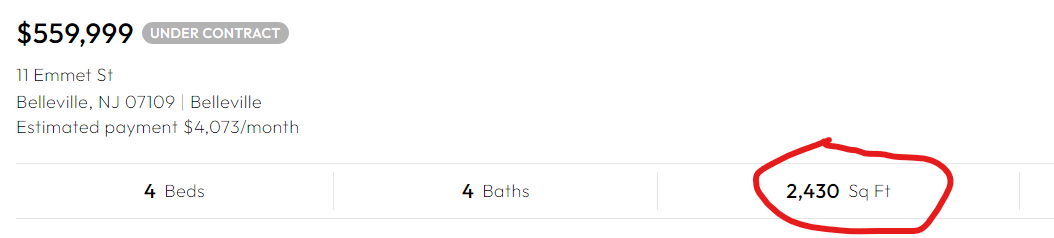

Now upload the dataframe to a csv to be used in tableau

In [37]:
NJ_real_estate.to_csv('NJ_real_estate_clean.csv', index= False)

## Exploratory Data Analysis using Tableau

In [38]:
%%html
<div class='tableauPlaceholder' id='viz1688583284973' style='position: relative'><noscript><a href='#'><img alt='Dashboard 1 ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ho&#47;Homes_comExploratoryDataAnalysis&#47;Dashboard1&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='Homes_comExploratoryDataAnalysis&#47;Dashboard1' /><param name='tabs' value='no' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;Ho&#47;Homes_comExploratoryDataAnalysis&#47;Dashboard1&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1688583284973');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.height='2227px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

In [39]:
original_data = NJ_real_estate[['price', 'beds', 'baths', 'sq_ft', 'description', 'realtor', 'agency','house_type', 'street', 'city', 'zip']]

In [40]:
original_data.describe()

,price,beds,baths,sq_ft
count,2.274000e+03,2274.000000,2274.000000,2274.000000
mean,5.462670e+05,2.806332,2.504529,1643.267238
std,4.967376e+05,1.049846,0.901386,771.631519
min,2.499900e+04,1.000000,1.000000,0.000000
25%,2.650000e+05,2.000000,2.000000,1146.000000
50%,4.147500e+05,3.000000,2.000000,1472.250000
75%,6.750000e+05,3.000000,3.000000,1967.325000
max,6.100000e+06,9.000000,9.000000,14080.000000


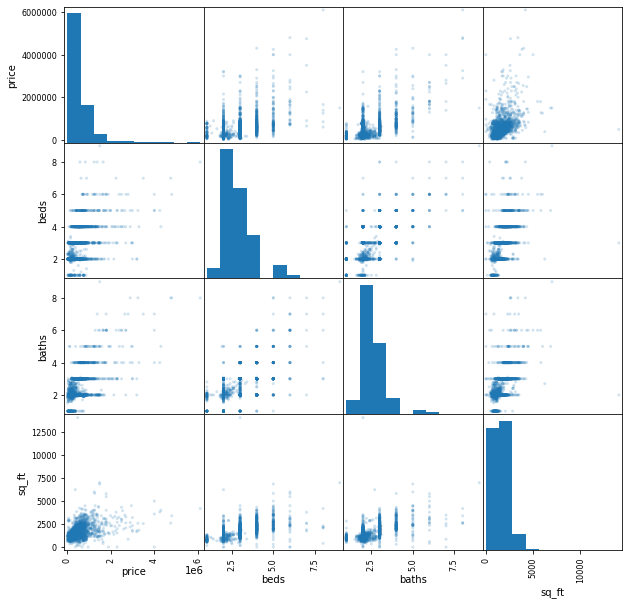

In [41]:
pd.plotting.scatter_matrix(original_data, alpha=0.2, figsize=(10, 10), diagonal='hist')
plt.show()

In [42]:
original_data.corr()

,price,beds,baths,sq_ft
price,1.000000,0.478611,0.611446,0.432887
beds,0.478611,1.000000,0.608214,0.585708
baths,0.611446,0.608214,1.000000,0.563256
sq_ft,0.432887,0.585708,0.563256,1.000000


## Preprocessing the description of the listing for further analysis

### Remove punctuation

In [43]:

# Define a regular expression pattern to match punctuation
pattern = r'[^\w\s]'

# Remove punctuation and lowercase from the text column
NJ_real_estate['description'] = NJ_real_estate['description'].str.replace(pattern, '')

# Print the modified DataFrame
NJ_real_estate.head()

,price,beds,baths,sq_ft,description,realtor,agency,house_type,street,city,zip,city_encoded,zip_encoded,house_type_encoded,agency_encoded
0,599999.0,3.0,3.0,1931.0,amazing opportunity to own waterfront property...,michael suppa,ward wight sothebys international realty,house,306 stephan ave,toms river,08753,398.0,359.0,1.0,720.0
1,899900.0,3.0,2.0,1734.0,rare find expanded ranch situated on picturesq...,michele ashkenazi,schecher realty,house,37 coolidge pl,west long branch,07764,426.0,177.0,1.0,658.0
2,899000.0,4.0,3.0,3224.0,welcome to 854 brown court this masterpiece is...,fraidy kaluszyner,exp realty,house,854 brown ct,toms river,08753,398.0,359.0,1.0,264.0
3,775000.0,5.0,3.0,2964.0,this wellmaintained twofamily investment prope...,gary mawson,exp realty,house,76 w 42nd st,bayonne,07002,17.0,1.0,1.0,264.0
4,729000.0,6.0,4.0,2331.0,welcome to your dream home in prime location n...,devora berger,keller williams shore properties,house,15 n crest pl,lakewood,08701,182.0,346.0,1.0,401.0


### Tokenize Column

In [44]:
#Create a function to tokenize the description column
def tokenize(column):
    tokens = nltk.word_tokenize(column)
    return [w for w in tokens if w.isalpha()]    

NJ_real_estate['tokenized_description'] = NJ_real_estate.apply(lambda x: tokenize(x['description']), axis=1)
NJ_real_estate.head()

,price,beds,baths,sq_ft,description,realtor,agency,house_type,street,city,zip,city_encoded,zip_encoded,house_type_encoded,agency_encoded,tokenized_description
0,599999.0,3.0,3.0,1931.0,amazing opportunity to own waterfront property...,michael suppa,ward wight sothebys international realty,house,306 stephan ave,toms river,08753,398.0,359.0,1.0,720.0,"[amazing, opportunity, to, own, waterfront, pr..."
1,899900.0,3.0,2.0,1734.0,rare find expanded ranch situated on picturesq...,michele ashkenazi,schecher realty,house,37 coolidge pl,west long branch,07764,426.0,177.0,1.0,658.0,"[rare, find, expanded, ranch, situated, on, pi..."
2,899000.0,4.0,3.0,3224.0,welcome to 854 brown court this masterpiece is...,fraidy kaluszyner,exp realty,house,854 brown ct,toms river,08753,398.0,359.0,1.0,264.0,"[welcome, to, brown, court, this, masterpiece,..."
3,775000.0,5.0,3.0,2964.0,this wellmaintained twofamily investment prope...,gary mawson,exp realty,house,76 w 42nd st,bayonne,07002,17.0,1.0,1.0,264.0,"[this, wellmaintained, twofamily, investment, ..."
4,729000.0,6.0,4.0,2331.0,welcome to your dream home in prime location n...,devora berger,keller williams shore properties,house,15 n crest pl,lakewood,08701,182.0,346.0,1.0,401.0,"[welcome, to, your, dream, home, in, prime, lo..."


### Remove Stop Words

In [45]:
#remove stop words from the column
def remove_stopwords(tokenized_column):
    stops = set(stopwords.words("english"))
    return [word for word in tokenized_column if not word in stops]

NJ_real_estate['tokenized_description'] = NJ_real_estate.apply(lambda x: remove_stopwords(x['tokenized_description']), axis=1)
NJ_real_estate.head()

,price,beds,baths,sq_ft,description,realtor,agency,house_type,street,city,zip,city_encoded,zip_encoded,house_type_encoded,agency_encoded,tokenized_description
0,599999.0,3.0,3.0,1931.0,amazing opportunity to own waterfront property...,michael suppa,ward wight sothebys international realty,house,306 stephan ave,toms river,08753,398.0,359.0,1.0,720.0,"[amazing, opportunity, waterfront, property, d..."
1,899900.0,3.0,2.0,1734.0,rare find expanded ranch situated on picturesq...,michele ashkenazi,schecher realty,house,37 coolidge pl,west long branch,07764,426.0,177.0,1.0,658.0,"[rare, find, expanded, ranch, situated, pictur..."
2,899000.0,4.0,3.0,3224.0,welcome to 854 brown court this masterpiece is...,fraidy kaluszyner,exp realty,house,854 brown ct,toms river,08753,398.0,359.0,1.0,264.0,"[welcome, brown, court, masterpiece, nestled, ..."
3,775000.0,5.0,3.0,2964.0,this wellmaintained twofamily investment prope...,gary mawson,exp realty,house,76 w 42nd st,bayonne,07002,17.0,1.0,1.0,264.0,"[wellmaintained, twofamily, investment, proper..."
4,729000.0,6.0,4.0,2331.0,welcome to your dream home in prime location n...,devora berger,keller williams shore properties,house,15 n crest pl,lakewood,08701,182.0,346.0,1.0,401.0,"[welcome, dream, home, prime, location, near, ..."


### Lemmatizing tokenized column

In [46]:
def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

# Apply the lemmatize_tokens function to the 'tokenized_column' of the DataFrame
NJ_real_estate['lemmatized_column'] = NJ_real_estate['tokenized_description'].apply(lemmatize_tokens)

NJ_real_estate.head()

,price,beds,baths,sq_ft,description,realtor,agency,house_type,street,city,zip,city_encoded,zip_encoded,house_type_encoded,agency_encoded,tokenized_description,lemmatized_column
0,599999.0,3.0,3.0,1931.0,amazing opportunity to own waterfront property...,michael suppa,ward wight sothebys international realty,house,306 stephan ave,toms river,08753,398.0,359.0,1.0,720.0,"[amazing, opportunity, waterfront, property, d...","[amazing, opportunity, waterfront, property, d..."
1,899900.0,3.0,2.0,1734.0,rare find expanded ranch situated on picturesq...,michele ashkenazi,schecher realty,house,37 coolidge pl,west long branch,07764,426.0,177.0,1.0,658.0,"[rare, find, expanded, ranch, situated, pictur...","[rare, find, expanded, ranch, situated, pictur..."
2,899000.0,4.0,3.0,3224.0,welcome to 854 brown court this masterpiece is...,fraidy kaluszyner,exp realty,house,854 brown ct,toms river,08753,398.0,359.0,1.0,264.0,"[welcome, brown, court, masterpiece, nestled, ...","[welcome, brown, court, masterpiece, nestled, ..."
3,775000.0,5.0,3.0,2964.0,this wellmaintained twofamily investment prope...,gary mawson,exp realty,house,76 w 42nd st,bayonne,07002,17.0,1.0,1.0,264.0,"[wellmaintained, twofamily, investment, proper...","[wellmaintained, twofamily, investment, proper..."
4,729000.0,6.0,4.0,2331.0,welcome to your dream home in prime location n...,devora berger,keller williams shore properties,house,15 n crest pl,lakewood,08701,182.0,346.0,1.0,401.0,"[welcome, dream, home, prime, location, near, ...","[welcome, dream, home, prime, location, near, ..."


### Correct speling in the description

In [47]:
NJ_real_estate['processed_description'] = NJ_real_estate['lemmatized_column'].apply(lambda x: ' '.join(x))

NJ_real_estate['corrected_text'] = ''

spell = SpellChecker()

for index, row in NJ_real_estate.iterrows():
    text = row['processed_description']
    words = text.split()

    corrected_words = []
    for word in words:
        corrected_word = spell.correction(word)
        if corrected_word is not None:  # Exclude None values
            corrected_words.append(corrected_word)


    corrected_text = ' '.join(corrected_words) if corrected_words else ''  # Join only if list is not empty
    NJ_real_estate.at[index, 'corrected_text'] = corrected_text

Save the cleaned data

In [48]:
NJ_real_estate.drop(['tokenized_description','lemmatized_column','processed_description'], axis=1, inplace=True)
NJ_real_estate.to_csv('NJ_real_estate_clean.csv', index= False)

## Prepare the features for the Model

Load back in the clean data

In [1]:
NJ_real_estate = pd.read_csv("NJ_real_estate_clean.csv")

NameError: name 'pd' is not defined

In [70]:
vectorizer = TfidfVectorizer()

vectorized_description = vectorizer.fit_transform(NJ_real_estate['corrected_text'])

In [71]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def log_transform(x):
    return np.log1p(x)

#Preprocess numerical variables
numeric_features = ['baths', 'beds', 'sq_ft']
scaler = StandardScaler()
numeric_data = scaler.fit_transform(NJ_real_estate[numeric_features])

#Combine TF-IDF vectors and numerical data
feature_matrix = pd.concat([pd.DataFrame(vectorized_description.toarray()), pd.DataFrame(numeric_data)], axis=1)
feature_matrix =  pd.concat([NJ_real_estate['price'], pd.DataFrame(vectorized_description.toarray(), columns=vectorizer.get_feature_names())], axis=1)

In [72]:
NJ_real_estate.columns

Index(['price', 'beds', 'baths', 'sq_ft', 'description', 'realtor', 'agency',
       'house_type', 'street', 'city', 'zip', 'city_encoded', 'zip_encoded',
       'house_type_encoded', 'agency_encoded', 'corrected_text'],
      dtype='object')

In [73]:
NJ_real_estate = NJ_real_estate[['price','beds','baths','sq_ft','city_encoded','zip_encoded','house_type_encoded','agency_encoded','corrected_text']]

In [75]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

# Log transform for numerical features
def log_transform(x):
    return np.log1p(x)

# Define columns
numeric_features = ['beds', 'baths', 'sq_ft']
text_feature = 'corrected_text'

# Preprocess numerical and text variables
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Replace NaN values with the mean
    ('scaler', StandardScaler()),
    ('log_transform', FunctionTransformer(log_transform))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('tfidf', TfidfVectorizer(), text_feature)
    ], remainder='passthrough'
)

# XGBoost model
model = XGBRegressor()

# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    NJ_real_estate.drop('price', axis=1),
    NJ_real_estate['price'],
    test_size=0.40,  # Adjust the test_size as needed
    random_state=42
)

y_train_transformed = log_transform(y_train)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train_transformed)

# Make predictions on the testing data
y_pred_transformed = pipeline.predict(X_test)

# Reverse log-transform for predictions
y_pred = np.expm1(y_pred_transformed)
#y_test_back_transformed = np.expm1(y_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
mse_formatted = f'${mse:.2f}'
print(f'Mean Squared Error on Test Set: {mse_formatted}')

<ipython-input-75-e50b77c2b28f>:14: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(x)


Mean Squared Error on Test Set: $97598006119.59


<ipython-input-75-e50b77c2b28f>:14: RuntimeWarning: invalid value encountered in log1p
  return np.log1p(x)


In [57]:
quartiles = pd.qcut(NJ_real_estate['price'], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
NJ_real_estate['quartile'] = quartiles

NJ_real_estate['tokenized_description'] = NJ_real_estate.apply(lambda x: tokenize(x['corrected_text']), axis=1)

In [58]:
# Calculate TF-IDF for words in descriptions per quartile
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(NJ_real_estate['corrected_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names())

# Add the quartile labels back to the DataFrame
tfidf_df['quartile'] = NJ_real_estate['quartile']

# Calculate the mean TF-IDF score for each word in each quartile
unique_words_per_quartile = {}
for quartile_label in NJ_real_estate['quartile'].unique():
    quartile_df = tfidf_df[tfidf_df['quartile'] == quartile_label]
    mean_tfidf = quartile_df.drop(columns=['quartile']).mean()
    unique_words = mean_tfidf.sort_values(ascending=False).index[:10]  # Get the top 5 unique words
    unique_words_per_quartile[quartile_label] = unique_words

# Display the most unique words per quartile
for quartile_label, unique_words in unique_words_per_quartile.items():
    print(f"Quartile {quartile_label}:")
    for word in unique_words:
        print(word)
    print()

Quartile Q3:
room
home
bedroom
floor
bath
living
new
full
space
kitchen

Quartile Q4:
room
home
floor
bedroom
bath
space
large
full
living
feature

Quartile Q2:
room
home
bedroom
new
bath
floor
space
living
kitchen
large

Quartile Q1:
home
new
room
bedroom
community
living
unit
bathroom
kitchen
bath



In [59]:
common_words_to_remove = ['offer','floor',"room", "bedroom", "bathroom", "kitchen", "living", "dining","kitchen",'home','bath', "area", "feature"]

# Sort quartile labels in order
sorted_quartiles = sorted(NJ_real_estate['quartile'].unique())

# Calculate unique words for each quartile
for quartile_label in sorted_quartiles:
    quartile_df = tfidf_df[tfidf_df['quartile'] == quartile_label]
    mean_tfidf = quartile_df.drop(columns=['quartile']).mean()
    
    # Sort words by mean TF-IDF score in descending order
    unique_words = mean_tfidf.sort_values(ascending=False).index.tolist()
    
    # Remove common words
    unique_words = [word for word in unique_words if word not in common_words_to_remove]
    
    unique_words_per_quartile[quartile_label] = unique_words[:10]  # Get the top 10 unique words

# Display the most unique words per quartile in order
for quartile_label in sorted_quartiles:
    print(f"Quartile {quartile_label}:")
    for word in unique_words_per_quartile[quartile_label]:
        print(word)
    print()

Quartile Q1:
new
community
unit
large
located
space
one
property
lot
water

Quartile Q2:
new
space
large
unit
full
closet
located
community
spacious
beautiful

Quartile Q3:
new
full
space
large
closet
garage
spacious
open
basement
beautiful

Quartile Q4:
space
large
full
custom
private
new
closet
suite
open
ceiling

